Importing All Libraries

In [ ]:
from google.colab import drive     # mounted to drive so to access everything from drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 114.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.2 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade tensorflow keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 52.6 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolve

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
import random
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
from skimage.feature import hog
from skimage import exposure
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import gradio as gr
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint



checking gpu is available or not


In [ ]:
import tensorflow as tf
print("GPUs Available:", len(tf.config.list_physical_devices('GPU')))


GPUs Available: 1


**Preparing For Data**

In [ ]:
folder_path = "/content/drive/MyDrive/ImplementationFinalProject/CT_images/Train"
filenames = []      #stores relative paths of image
categories = []     #stores category/label of image...e.g. stone ,normal

for category in os.listdir(folder_path):    #gets a list of all subfolders inside Train
    category_path = os.path.join(folder_path, category)  #joins folder path and each category in category folder

    if os.path.isdir(category_path):  #valid directory
        for filename in os.listdir(category_path):   #loop through all images in category_path
            filenames.append(os.path.join(category, filename))    #joins filename to category and append it to filenames list
            categories.append(category)   #category is appended to categories list

df = pd.DataFrame({            #structured dataframe
    'filename': filenames,
    'category': categories
})

In [ ]:
#dataset size
df.shape

(2984, 2)

2984 samples in dataset and 2 features

In [ ]:
df.head()             #top 5 entries

,filename,category
0,Stone/Stone- (104).jpg,Stone
1,Stone/Stone- (111).jpg,Stone
2,Stone/Stone- (108).jpg,Stone
3,Stone/Stone- (107).jpg,Stone
4,Stone/Stone- (11).jpg,Stone


In [ ]:
df.tail()          #last 5 entries

,filename,category
2979,Normal/Normal- (2148).jpg,Normal
2980,Normal/Normal- (215).jpg,Normal
2981,Normal/Normal- (2165).jpg,Normal
2982,Normal/Normal- (2144).jpg,Normal
2983,Normal/Normal- (2154).jpg,Normal


<Axes: xlabel='category'>

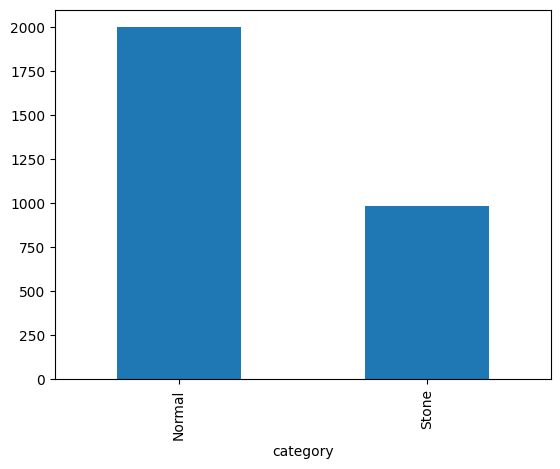

In [ ]:
df['category'].value_counts().plot.bar()

There are total 2000 normal and 984 stone images in dataset

**Visualizing Data**

Selected file: Normal/Normal- (2253).jpg
Selected image Size: 512 x 512 pixels


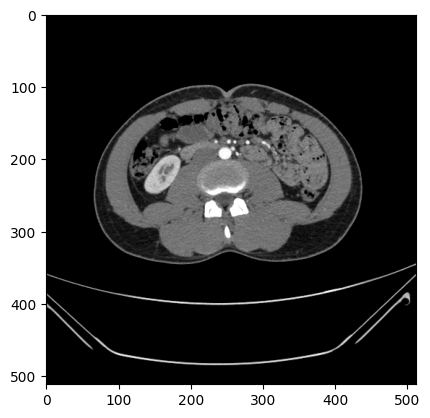

In [ ]:
from PIL import Image    #for displaying image size


sample = random.choice(filenames)    #selects random file from filenames list
print("Selected file:", sample)       #selected file
image_path = f"/content/drive/MyDrive/ImplementationFinalProject/CT_images/Train/{sample}"    #image path
image = load_img(image_path)       #reads an image (keras utility function)

# Open the image using PIL to get its size
with Image.open(image_path) as img:
    width, height = img.size
    print(f"Selected image Size: {width} x {height} pixels")


plt.imshow(image)  #renders an image in colab (matplotlib)

Above shows that images in dataset are of varying size

**Preparing Data=>Splitting data before augmentation to avoid data leakage**
1)split dataset into training set 70% and validation set 30%

In [ ]:
df['target'] = df['category'].map({'Normal': 0, 'Stone': 1})
train_df, validate_df = train_test_split(df, test_size=0.30, random_state=42,stratify=df['target'])
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [ ]:
print("Original Class Distribution:")
print(df['target'].value_counts(normalize=True))

print("\nTrain Class Distribution:")
print(train_df['target'].value_counts(normalize=True))

print("\nValidation Class Distribution:")
print(validate_df['target'].value_counts(normalize=True))

Original Class Distribution:
target
0    0.670241
1    0.329759
Name: proportion, dtype: float64

Train Class Distribution:
target
0    0.670019
1    0.329981
Name: proportion, dtype: float64

Validation Class Distribution:
target
0    0.670759
1    0.329241
Name: proportion, dtype: float64


<Axes: xlabel='category'>

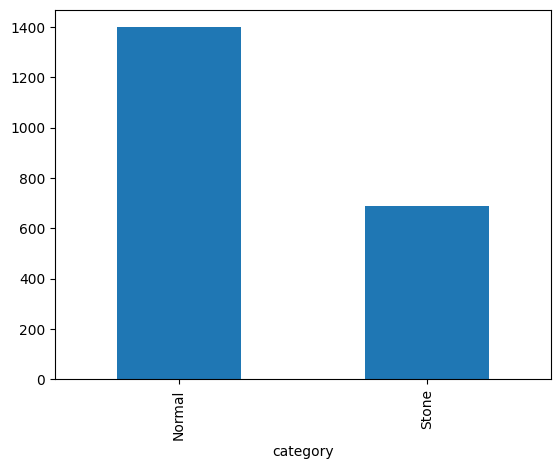

In [ ]:
train_df['category'].value_counts().plot.bar()

**for training there are 1399 normal images and 689 stone images**

In [ ]:
train_df.shape           #total 2088 samples

(2088, 3)

In [ ]:
print(train_df.columns)

Index(['filename', 'category', 'target'], dtype='object')


In [ ]:
train_df['category'].value_counts()

,count
category,
Normal,1399
Stone,689


<Axes: xlabel='category'>

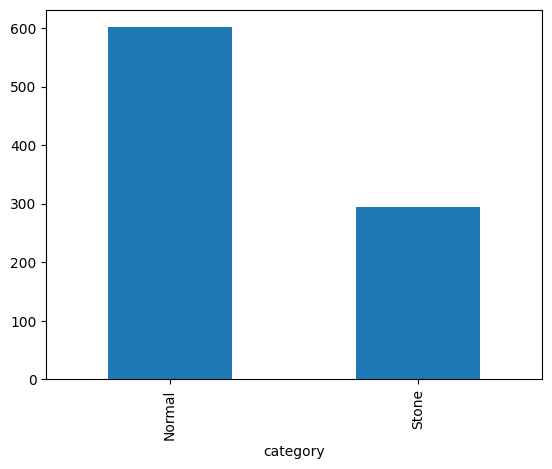

In [ ]:
validate_df['category'].value_counts().plot.bar()

**for validation there are 601 normal images and 295 stone images**

In [ ]:
validate_df.shape           #total 896 samples

(896, 3)

In [ ]:
validate_df['category'].value_counts()

,count
category,
Normal,601
Stone,295


In [ ]:
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(validate_df)}")

#check data leakage to overcome overfitting
common_samples = train_df.merge(validate_df, how='inner', on=train_df.columns.tolist())
print(f"Common samples between train and validation: {len(common_samples)}")    #if 0 then split is good


Training set size: 2088
Validation set size: 896
Common samples between train and validation: 0


In [ ]:
#verify features and labels to ensure data qualoty before training
print(train_df.head())
print(validate_df.head())
print(train_df.info())  # To check for missing values
print(validate_df.info())


                   filename category  target
0  Normal/Normal- (951).jpg   Normal       0
1    Stone/Stone- (645).jpg    Stone       1
2  Normal/Normal- (934).jpg   Normal       0
3  Normal/Normal- (430).jpg   Normal       0
4    Stone/Stone- (498).jpg    Stone       1
                    filename category  target
0  Normal/Normal- (1346).jpg   Normal       0
1    Normal/Normal- (52).jpg   Normal       0
2   Normal/Normal- (106).jpg   Normal       0
3  Normal/Normal- (1796).jpg   Normal       0
4     Stone/Stone- (195).jpg    Stone       1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2088 entries, 0 to 2087
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2088 non-null   object
 1   category  2088 non-null   object
 2   target    2088 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 49.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 3 columns)

**Data Preprocessing**

custom data generator


In [ ]:

import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import Sequence, img_to_array
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

class CustomDataGenerator(Sequence):
    def __init__(self, dataframe, directory, x_col, y_col,
                 batch_size=32, shuffle=True, target_size=(224, 224), preview=False):
        self.dataframe = dataframe
        self.directory = directory
        self.x_col = x_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.target_size = target_size
        self.preview = preview  # Whether to preview images
        self.indexes = np.arange(len(self.dataframe))
        if self.shuffle:
            np.random.shuffle(self.indexes)
        self.n = 0  # Current batch index

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.dataframe.iloc[batch_indexes]

        images = []
        labels = []

        for i, row in batch_data.iterrows():
            img_path = os.path.join(self.directory, row[self.x_col])
            img = load_img(img_path, target_size=self.target_size)
            img_array = img_to_array(img) / 255.0  # Normalize
            images.append(img_array)
            labels.append(row[self.y_col])

        X = np.array(images)
        y = np.array(labels)


        if self.preview and index == 0:
            plt.imshow(X[0])
            plt.title(f"Label: {y[0]}")
            plt.axis('off')
            plt.show()

        return X, y

    def __next__(self):
        if self.n >= self.__len__():
            self.n = 0
        result = self.__getitem__(self.n)
        self.n += 1
        return result

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


**create data generator train and validation**



*   Used custom data generator for loading batches of images instead of entire dataset
*   Resizes, normalizes, or augments images dynamically.




In [ ]:
# Create custom generators
train_generator = CustomDataGenerator(
    dataframe=train_df,
    directory="/content/drive/MyDrive/ImplementationFinalProject/CT_images/Train/",
    x_col='filename',
    y_col='target',
    batch_size=15,
    shuffle=True,
    target_size=(224, 224)
)

validation_generator = CustomDataGenerator(
    dataframe=validate_df,
    directory="/content/drive/MyDrive/ImplementationFinalProject/CT_images/Train/",
    x_col='filename',
    y_col='target',
    batch_size=15,
    shuffle=False,
    target_size=(224, 224)
)

visualizing o/p of data generator

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)   #select one random image from train_df and reset index so that row will start from 0

example_generator = CustomDataGenerator(
    example_df,
    "/content/drive/MyDrive/ImplementationFinalProject/CT_images/Train/",
    x_col='filename',
    y_col='category',
    batch_size=1,   #batch size of 1 as single image is there
    shuffle=False #no shuffling for single sample
)

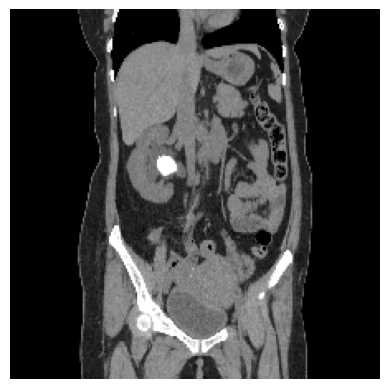

Class Label (One-Hot Encoded): Stone


In [ ]:
#view randomly selected image
#to ensure data preprocessing(data augmentation) done correctly

# Instead of using next(), iterate through the generator manually
for image_batch, label_batch in example_generator:
    # Display the image
    plt.imshow(image_batch[0])  # Display first (and only) image
    plt.axis("off")  # Hide axes
    plt.show()

    # Print the corresponding label
    print("Class Label (One-Hot Encoded):", label_batch[0])
    break  # Exit the loop after processing the first batch


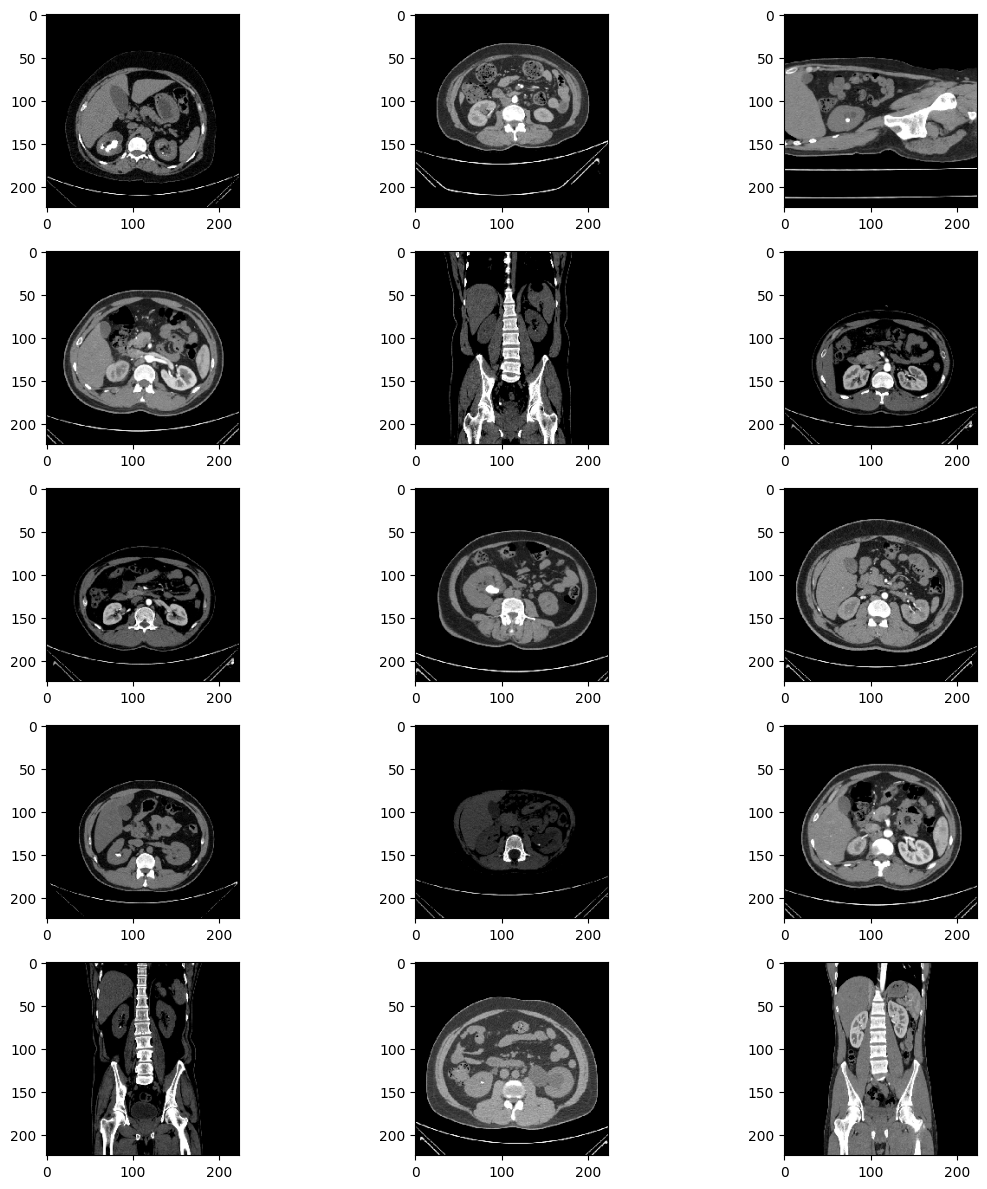

In [ ]:
#visualize multiple images
X_batch, Y_batch = next(train_generator)  # Get a full batch from the training generator

plt.figure(figsize=(12, 12))  # Set figure size
for i in range(15):
    plt.subplot(5, 3, i+1)  # 5 rows, 3 columns
    plt.imshow(X_batch[i])  # Show a different image from the batch

plt.tight_layout()  # Avoid overlapping
plt.show()


**Building CNN Model**

In [ ]:
from tensorflow.keras.layers import LeakyReLU


In [ ]:
from tensorflow.keras.optimizers import Adamax


In [ ]:
from tensorflow.keras.mixed_precision import set_global_policy

set_global_policy('mixed_float16')  # Enable mixed precision

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense

# Build the CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(None, None, 3)),  # Variable input size
    MaxPooling2D((2, 2)),        #downsampling layer used in CNNs to reduce the spatial dimensions (height & width) of feature maps. keeps max value from each 2*2 square
    Conv2D(64, (3, 3), activation='relu'),  #relu is used in hidden layers makes -ve neurons positive as f(x) = max(0,x)
    GlobalAveragePooling2D(),  # Adaptive pooling layer for handling variable input size
    Dense(1, activation='sigmoid')  # used Binary classification ...sigmoid is used in binary op layer ..it gives how confident model is for class 1
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, None, None, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, None, None, 64) │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,457 (76.00 KB)

 Trainable params: 19,457 (76.00 KB)

 Non-trainable params: 0 (0.00 B)


**Call backs => early stop to prevent overfitting after 3 epochs by halting training when the model's performance on the validation set ceases to improve.**

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#The callback will monitor the validation loss during training (It represents the error (or loss) of the model when it is evaluated on the validation set)
#The model will wait for 3 epochs without improvement in validation loss before stopping.
#When training stops, it restores the model weights to the point with the best performance on the validation set.


**Learning Rate Reduction
We will reduce the learning rate when accuracy is not increasing for 3
steps**

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001
)
#callback monitors validation loss during training
#reduce learning rate by 0.5
#callback will wait for 3 epochs without improvement in validation loss before reducing the learning rate
#learning rate wont reduce by min_lr


In [ ]:
callbacks = [earlystop, reduce_lr]    #list of callbacks that will be used during model training

**Model fitting**

In [ ]:
# Compiling the model
from tensorflow.keras.optimizers import Adam  # Import the Adam optimizer

model.compile(loss='binary_crossentropy',  #cz two classes are there normal and stone
              optimizer=Adam(learning_rate=0.01),      #used to minimise the loss function during training
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint('model_best.h5', save_best_only=True)     #best version of model weights will be saved in model_best.h5

history = model.fit(
    train_generator,             #automtically handles data augmentation,resizing,batching
    epochs=50,                     #50 epochs
    validation_data=validation_generator,                 #performance is validated on validation data
    validation_steps=validate_df.shape[0] // 32,          #batch size 32..divides validation samples by batch size
    steps_per_epoch=train_df.shape[0] // 32,              #traning steps per epoch
    callbacks=[checkpoint_callback, *callbacks]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6413 - loss: 0.6299

65/65 ━━━━━━━━━━━━━━━━━━━━ 568s 9s/step - accuracy: 0.6416 - loss: 0.6298 - val_accuracy: 0.6857 - val_loss: 0.5958 - learning_rate: 0.0100
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6855 - loss: 0.6151

65/65 ━━━━━━━━━━━━━━━━━━━━ 224s 4s/step - accuracy: 0.6853 - loss: 0.6152 - val_accuracy: 0.6857 - val_loss: 0.5903 - learning_rate: 0.0100
Epoch 3/50
10/65 ━━━━━━━━━━━━━━━━━━━━ 1:10 1s/step - accuracy: 0.7616 - loss: 0.5313

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 316ms/step - accuracy: 0.7433 - loss: 0.5319 - val_accuracy: 0.6857 - val_loss: 0.5924 - learning_rate: 0.0100
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6543 - loss: 0.5927

65/65 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.6544 - loss: 0.5927 - val_accuracy: 0.6857 - val_loss: 0.5668 - learning_rate: 0.0100
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - accuracy: 0.6364 - loss: 0.6088

65/65 ━━━━━━━━━━━━━━━━━━━━ 61s 946ms/step - accuracy: 0.6370 - loss: 0.6083 - val_accuracy: 0.6857 - val_loss: 0.5517 - learning_rate: 0.0100
Epoch 6/50
10/65 ━━━━━━━━━━━━━━━━━━━━ 23s 419ms/step - accuracy: 0.6626 - loss: 0.5469

65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.6491 - loss: 0.5508 - val_accuracy: 0.6905 - val_loss: 0.5482 - learning_rate: 0.0100
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.6556 - loss: 0.5635

65/65 ━━━━━━━━━━━━━━━━━━━━ 82s 910ms/step - accuracy: 0.6560 - loss: 0.5634 - val_accuracy: 0.7667 - val_loss: 0.5210 - learning_rate: 0.0100
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.7185 - loss: 0.5285

65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 635ms/step - accuracy: 0.7187 - loss: 0.5284 - val_accuracy: 0.8214 - val_loss: 0.4677 - learning_rate: 0.0100
Epoch 9/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.7783 - loss: 0.5061 - val_accuracy: 0.7857 - val_loss: 0.4759 - learning_rate: 0.0100
Epoch 10/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.7838 - loss: 0.4753

65/65 ━━━━━━━━━━━━━━━━━━━━ 82s 681ms/step - accuracy: 0.7839 - loss: 0.4750 - val_accuracy: 0.8262 - val_loss: 0.4361 - learning_rate: 0.0100
Epoch 11/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8356 - loss: 0.4177

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - accuracy: 0.8355 - loss: 0.4177 - val_accuracy: 0.8167 - val_loss: 0.4149 - learning_rate: 0.0100
Epoch 12/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.7875 - loss: 0.4320 - val_accuracy: 0.7714 - val_loss: 0.4646 - learning_rate: 0.0100
Epoch 13/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 316ms/step - accuracy: 0.8350 - loss: 0.4217 - val_accuracy: 0.8310 - val_loss: 0.4420 - learning_rate: 0.0100
Epoch 14/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8064 - loss: 0.4215

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - accuracy: 0.8067 - loss: 0.4212 - val_accuracy: 0.7952 - val_loss: 0.3991 - learning_rate: 0.0100
Epoch 15/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.7931 - loss: 0.4523 - val_accuracy: 0.7500 - val_loss: 0.4782 - learning_rate: 0.0100
Epoch 16/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 235ms/step - accuracy: 0.8106 - loss: 0.4232 - val_accuracy: 0.8048 - val_loss: 0.4028 - learning_rate: 0.0100
Epoch 17/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8047 - loss: 0.4336

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - accuracy: 0.8048 - loss: 0.4336 - val_accuracy: 0.8286 - val_loss: 0.3945 - learning_rate: 0.0100
Epoch 18/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.7883 - loss: 0.4080 - val_accuracy: 0.7762 - val_loss: 0.4307 - learning_rate: 0.0100
Epoch 19/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8051 - loss: 0.4333

65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.8053 - loss: 0.4330 - val_accuracy: 0.8238 - val_loss: 0.3918 - learning_rate: 0.0100
Epoch 20/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.8064 - loss: 0.4106 - val_accuracy: 0.7714 - val_loss: 0.4363 - learning_rate: 0.0100
Epoch 21/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.7627 - loss: 0.4311 - val_accuracy: 0.8429 - val_loss: 0.3949 - learning_rate: 0.0100
Epoch 22/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8219 - loss: 0.4031

65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.8219 - loss: 0.4031 - val_accuracy: 0.8429 - val_loss: 0.3868 - learning_rate: 0.0100
Epoch 23/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.8029 - loss: 0.4405 - val_accuracy: 0.8119 - val_loss: 0.3890 - learning_rate: 0.0100
Epoch 24/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.8536 - loss: 0.3266 - val_accuracy: 0.8310 - val_loss: 0.4243 - learning_rate: 0.0100
Epoch 25/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8055 - loss: 0.4291

65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 374ms/step - accuracy: 0.8058 - loss: 0.4286 - val_accuracy: 0.8286 - val_loss: 0.3838 - learning_rate: 0.0100
Epoch 26/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.8342 - loss: 0.3826 - val_accuracy: 0.7952 - val_loss: 0.4130 - learning_rate: 0.0100
Epoch 27/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8222 - loss: 0.3823 - val_accuracy: 0.8381 - val_loss: 0.4006 - learning_rate: 0.0100
Epoch 28/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8384 - loss: 0.3623

65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.8384 - loss: 0.3625 - val_accuracy: 0.8214 - val_loss: 0.3791 - learning_rate: 0.0100
Epoch 29/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.8466 - loss: 0.3654 - val_accuracy: 0.8190 - val_loss: 0.3923 - learning_rate: 0.0100
Epoch 30/50
10/65 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.8618 - loss: 0.3588

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8490 - loss: 0.4186 - val_accuracy: 0.8286 - val_loss: 0.3705 - learning_rate: 0.0100
Epoch 31/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8394 - loss: 0.3602

65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.8393 - loss: 0.3605 - val_accuracy: 0.8238 - val_loss: 0.3703 - learning_rate: 0.0100
Epoch 32/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.8049 - loss: 0.4311 - val_accuracy: 0.8190 - val_loss: 0.3862 - learning_rate: 0.0100
Epoch 33/50
10/65 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.8229 - loss: 0.3594

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8563 - loss: 0.3234 - val_accuracy: 0.8571 - val_loss: 0.3591 - learning_rate: 0.0100
Epoch 34/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.8332 - loss: 0.3614 - val_accuracy: 0.8262 - val_loss: 0.3700 - learning_rate: 0.0100
Epoch 35/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8368 - loss: 0.3761

65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.8369 - loss: 0.3762 - val_accuracy: 0.8357 - val_loss: 0.3536 - learning_rate: 0.0100
Epoch 36/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.8365 - loss: 0.3762 - val_accuracy: 0.8476 - val_loss: 0.3556 - learning_rate: 0.0100
Epoch 37/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8193 - loss: 0.3973

65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.8196 - loss: 0.3968 - val_accuracy: 0.8690 - val_loss: 0.3385 - learning_rate: 0.0100
Epoch 38/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.8542 - loss: 0.3562 - val_accuracy: 0.8310 - val_loss: 0.4399 - learning_rate: 0.0100
Epoch 39/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.8713 - loss: 0.3187 - val_accuracy: 0.7929 - val_loss: 0.4198 - learning_rate: 0.0100
Epoch 40/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8716 - loss: 0.3363

65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.8716 - loss: 0.3362 - val_accuracy: 0.8643 - val_loss: 0.3336 - learning_rate: 0.0100
Epoch 41/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.8838 - loss: 0.2959 - val_accuracy: 0.8143 - val_loss: 0.3538 - learning_rate: 0.0100
Epoch 42/50
10/65 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.7984 - loss: 0.4165

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8110 - loss: 0.3997 - val_accuracy: 0.8857 - val_loss: 0.2910 - learning_rate: 0.0100
Epoch 43/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9034 - loss: 0.2837

65/65 ━━━━━━━━━━━━━━━━━━━━ 27s 149ms/step - accuracy: 0.9033 - loss: 0.2839 - val_accuracy: 0.8881 - val_loss: 0.2793 - learning_rate: 0.0100
Epoch 44/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8987 - loss: 0.2815

65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.8986 - loss: 0.2815 - val_accuracy: 0.8762 - val_loss: 0.2790 - learning_rate: 0.0100
Epoch 45/50
10/65 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.8775 - loss: 0.3721

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.8683 - loss: 0.3265 - val_accuracy: 0.8714 - val_loss: 0.2787 - learning_rate: 0.0100
Epoch 46/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8927 - loss: 0.2778

65/65 ━━━━━━━━━━━━━━━━━━━━ 27s 145ms/step - accuracy: 0.8927 - loss: 0.2779 - val_accuracy: 0.9000 - val_loss: 0.2629 - learning_rate: 0.0100
Epoch 47/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9080 - loss: 0.2203

65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.9080 - loss: 0.2210 - val_accuracy: 0.9238 - val_loss: 0.2495 - learning_rate: 0.0100
Epoch 48/50
10/65 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.8748 - loss: 0.3334

65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.8736 - loss: 0.3422 - val_accuracy: 0.8952 - val_loss: 0.2446 - learning_rate: 0.0100
Epoch 49/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9014 - loss: 0.2830

65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 381ms/step - accuracy: 0.9012 - loss: 0.2832 - val_accuracy: 0.9143 - val_loss: 0.2284 - learning_rate: 0.0100
Epoch 50/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9096 - loss: 0.2519

65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.9096 - loss: 0.2520 - val_accuracy: 0.9095 - val_loss: 0.2109 - learning_rate: 0.0100


training and validation in each epoch => 1)training phase = model trained batch by batch using training dataset
2)updates weights using backpropogation and optmization
3)process continues until model has seen all training samples once

validation phase
1)after training on entire dataset for one epoch the model is evaulated on valifation dataset
2)validation loss, accuracy calculated no weight updates
3)monitor generalization

early stopping occurs if validation loss hasnt improved for certain no. of epochs(patience)

**Visualize the training History using history object returned by model.fit() method which maintains the overall history of training**

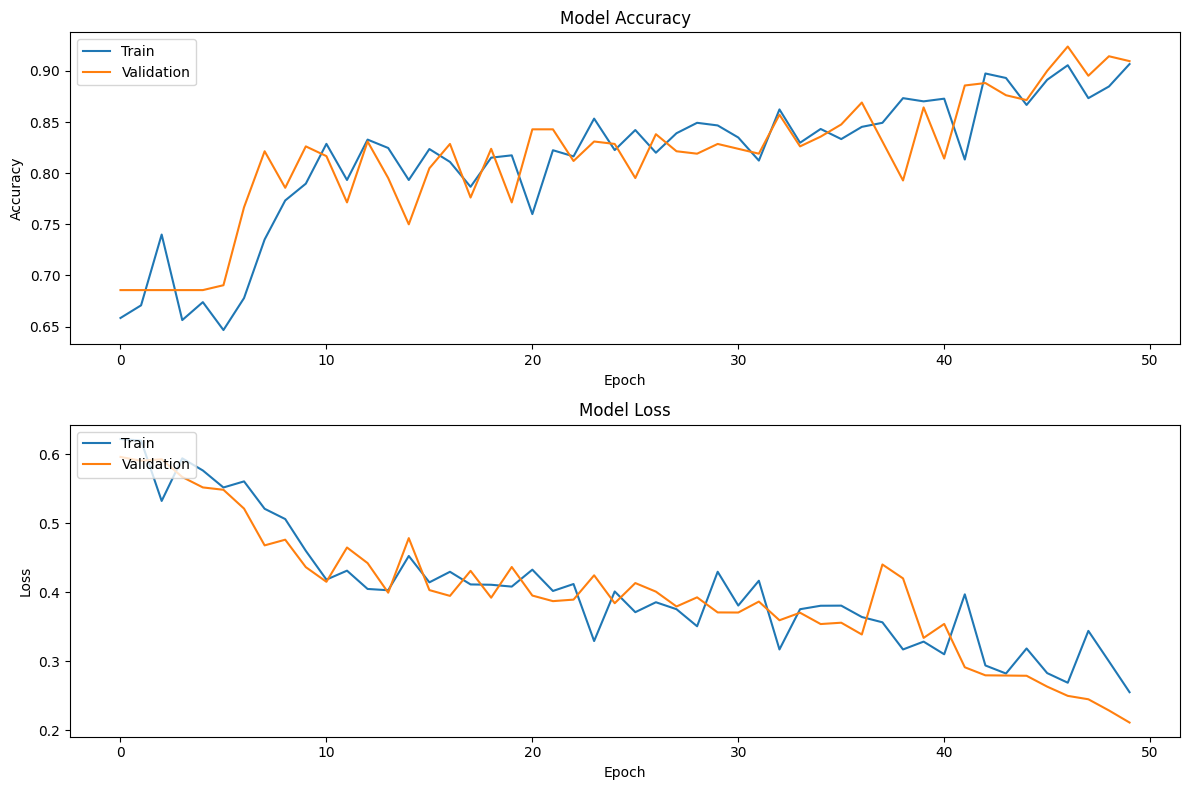

In [ ]:
# Plotting the training history
plt.figure(figsize=(12, 8))

# Plot training & validation accuracy values
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

This shows that model has training accuracy ~ validation accuracy (both are increasing) and training loss ~ validation loss (both are decreasing) . So the model has accurately learnt and trained no overfitting and underfitting.

**Saving the CNN Model**

In [ ]:
# Saving the Model...its not compulsory as we are already saving the best model ..but if best model and last epoch model is diff so
model.save('/content/drive/MyDrive/ImplementationFinalProject/kidney_stone_detection_model_cnn.h5')

**Downloading model locally**

In [ ]:
from google.colab import files
files.download("kidney_stone_detection_model_cnn.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# from tensorflow.keras.models import load_model
# #reload the model once saved
# model = load_model("kidney_stone_detection_model_cnn.h5")  # Load the saved model


Plot ROC curve(Receiver Operating Characteristic) to find out performace of binary classifier

With help of this find our threshold value that indicates good balance between specificity(precision) and sensitivity(recall)

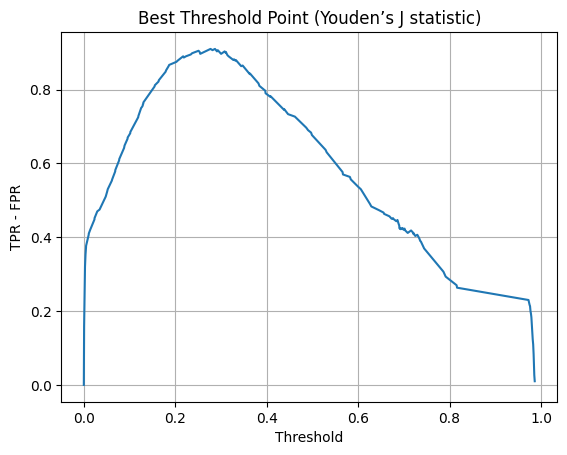

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(test_df['target'], predict)
plt.plot(thresholds, tpr - fpr)
plt.xlabel('Threshold')
plt.ylabel('TPR - FPR')
plt.title('Best Threshold Point (Youden’s J statistic)')
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import roc_curve
import numpy as np

fpr, tpr, thresholds = roc_curve(test_df['target'], predict)
youden_j = tpr - fpr
best_threshold = thresholds[np.argmax(youden_j)]

print(f"Best threshold based on Youden's J statistic: {best_threshold:.4f}")


Best threshold based on Youden's J statistic: 0.2771


In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(test_df['target'], predict)
print(f"AUC Score: {auc:.4f}")    #auc near to 1 indicates good model


AUC Score: 0.9719


**Testing Data**

In [ ]:
predict = model.predict(test_generator, steps=steps)  # Get predictions

# Probabilities for class 1 (Kidney Stone)
y_probs = predict[:, 0]  # Assuming your model has a single output node for binary classification

60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step


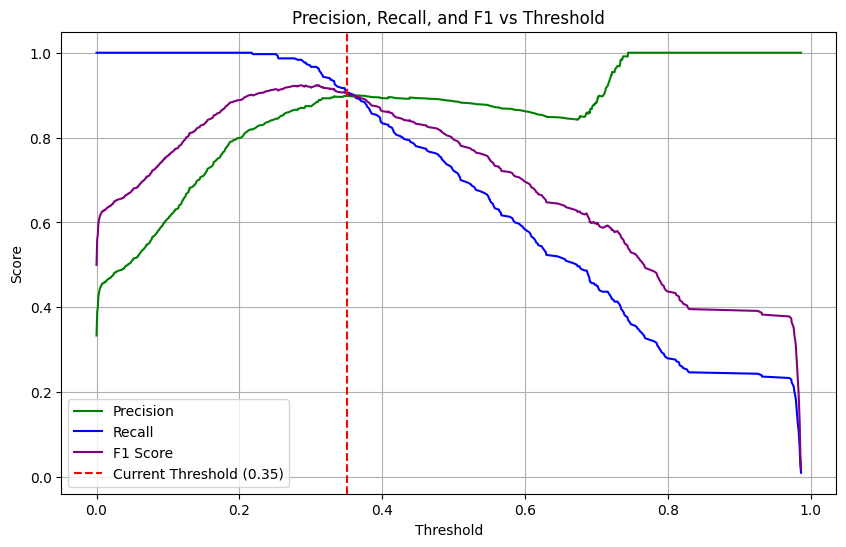

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score
import matplotlib.pyplot as plt
import numpy as np

precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='green')
plt.plot(thresholds, recall[:-1], label='Recall', color='blue')
plt.plot(thresholds, f1[:-1], label='F1 Score', color='purple')
plt.axvline(x=0.35, color='red', linestyle='--', label='Current Threshold (0.35)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load test data
test_folder_path = "/content/drive/MyDrive/ImplementationFinalProject/CT_images/Test"
test_filenames = []  # filenames
test_categories = []  # categories

for category in os.listdir(test_folder_path):
    test_category_path = os.path.join(test_folder_path, category)

    if os.path.isdir(test_category_path):
        for filename in os.listdir(test_category_path):
            test_filenames.append(os.path.join(category, filename))
            test_categories.append(category)

# Create test DataFrame
test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': test_categories
})

# Create a 'target' column with numerical labels
test_df['target'] = test_df['category'].map({'Normal': 0, 'Stone': 1})

# Use CustomDataGenerator for testing
test_generator = CustomDataGenerator(
    dataframe=test_df,
    directory="/content/drive/MyDrive/ImplementationFinalProject/CT_images/Test/",
    x_col='filename',
    y_col='target',
    batch_size=15,
    shuffle=False  # No shuffling for test data
)

# Generate predictions
steps = int(np.ceil(test_df.shape[0] / 15))  # Ensure integer steps
predict = model.predict(test_generator, steps=steps)

# Convert predictions to labels
threshold = 0.36
test_df['predicted category'] = ['Stone' if p > threshold else 'Normal' for p in predict]

# Display the DataFrame
print(test_df)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step
                      filename category  target predicted category
0      Stone/Stone- (1010).jpg    Stone       1              Stone
1      Stone/Stone- (1007).jpg    Stone       1              Stone
2      Stone/Stone- (1003).jpg    Stone       1              Stone
3      Stone/Stone- (1004).jpg    Stone       1              Stone
4      Stone/Stone- (1009).jpg    Stone       1              Stone
..                         ...      ...     ...                ...
895  Normal/Normal- (2587).jpg   Normal       0             Normal
896  Normal/Normal- (2597).jpg   Normal       0             Normal
897  Normal/Normal- (2594).jpg   Normal       0             Normal
898  Normal/Normal- (2585).jpg   Normal       0             Normal
899  Normal/Normal- (2584).jpg   Normal       0             Normal

[900 rows x 4 columns]


**Visualize the predicted and actual data**

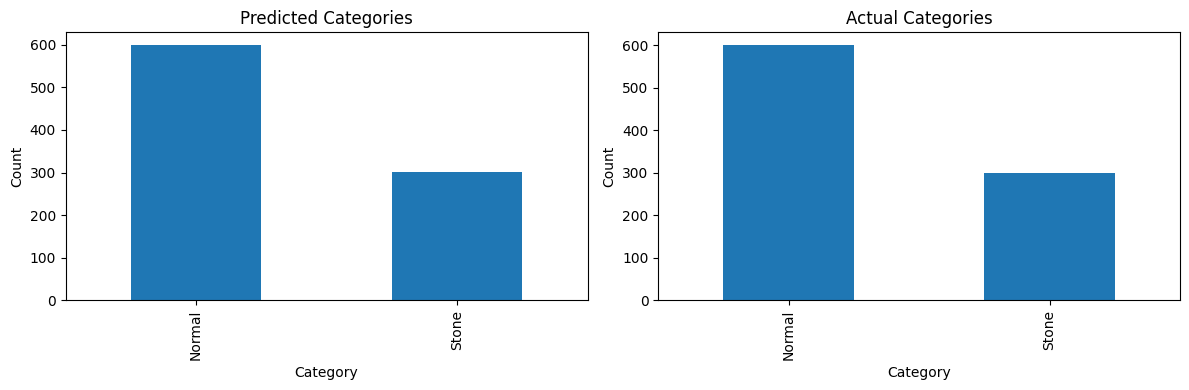

In [ ]:
plt.figure(figsize=(12, 4))

# Plot the first bar plot (predicted category)
plt.subplot(1, 2, 1)
test_df['predicted category'].value_counts().plot.bar()
plt.title('Predicted Categories')
plt.xlabel('Category')
plt.ylabel('Count')

# Plot the second bar plot (actual category)
plt.subplot(1, 2, 2)
test_df['category'].value_counts().plot.bar()
plt.title('Actual Categories')
plt.xlabel('Category')
plt.ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
# Count of predicted categories
predicted_counts = test_df['predicted category'].value_counts()
print("Predicted Categories:")
print(predicted_counts)

# Count of actual categories
actual_counts = test_df['category'].value_counts()
print("\nActual Categories:")
print(actual_counts)

Predicted Categories:
predicted category
Normal    599
Stone     301
Name: count, dtype: int64

Actual Categories:
category
Normal    600
Stone     300
Name: count, dtype: int64


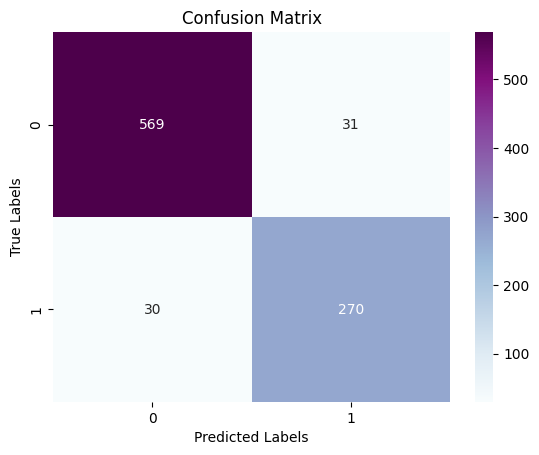

In [ ]:
cm = confusion_matrix(test_df['category'], test_df['predicted category'])

sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

**Confusion matrix=>**
 *Positive class is of stones ..as mentioned in binary classification(1)
Negative class is of normal ..as mentioned in binary classification(0)*

*  TP = 569 (correctly predicted stones)
*  FP = 31 (predicted as stone but actual was normal)
*   FN = 30 (predicted as normal but actual was stone)
*   TN = 270 (correctly predicted as normal)






In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = test_df['target']
y_pred = (predict > 0.36).astype(int)  # Use your current threshold

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Optional: more detailed metrics
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Stone']))


Confusion Matrix:
 [[569  31]
 [ 30 270]]

Classification Report:

              precision    recall  f1-score   support

      Normal       0.95      0.95      0.95       600
       Stone       0.90      0.90      0.90       300

    accuracy                           0.93       900
   macro avg       0.92      0.92      0.92       900
weighted avg       0.93      0.93      0.93       900



In [ ]:
from sklearn import metrics

# Assuming 'test_df' contains your test data and predictions
y_true = test_df['target']  # Actual labels (0 for Normal, 1 for Stone)
y_pred = test_df['predicted category'].map({'Normal': 0, 'Stone': 1})  # Predicted labels

# Compute Accuracy
accuracy = metrics.accuracy_score(y_true, y_pred)*100

# Compute Precision, Recall, F1-score
precision = metrics.precision_score(y_true, y_pred)*100
recall = metrics.recall_score(y_true, y_pred)*100
f1 = metrics.f1_score(y_true, y_pred)*100

# Compute Confusion Matrix
conf_matrix = metrics.confusion_matrix(y_true, y_pred)

# Compute ROC-AUC (if applicable)
roc_auc = metrics.roc_auc_score(y_true, y_pred)

# Print Results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")


Accuracy: 93.22
Precision: 89.70
Recall: 90.00
F1 Score: 89.85
ROC-AUC Score: 0.92


This indicates that overall model's accuracy is 93.22
Precision is 89.70
recall is 90.00
F1 score is 89.85
ROC- AUC is 0.92

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.8375 - loss: 0.3122
Test Loss: 0.24367034435272217
Test Accuracy: 0.8755555748939514


The model's accuracy is 87.55 %
*This is model's evaluation during testing*

**SVM**

In [ ]:
#Defining a function to read images from the train and test folders
def read_images(path):
    images_list = []          #list for images
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path,filename))    #read the image from full path joined
        if img is not None: #if image isnt there then rerurn none
            images_list.append(img)   #otherwise add full path in images_list
    return images_list

In [ ]:
#Reading train images from the normal and stone folders

train_normal = read_images('/content/drive/MyDrive/ImplementationFinalProject/CT_images/Train/Normal')
train_stone = read_images('/content/drive/MyDrive/ImplementationFinalProject/CT_images/Train/Stone')

In [ ]:
#Creating a list of labels for training
labels = ['Normal' for item in train_normal] + ['Stone' for item in train_stone]

In [ ]:

# Define the path to your training images folders
train_images_normal = '/content/drive/MyDrive/ImplementationFinalProject/CT_images/Train/Normal'
train_images_stone = '/content/drive/MyDrive/ImplementationFinalProject/CT_images/Train/Stone'

# List all image files in both folders, filtering valid image files
image_files_normal = [f for f in os.listdir(train_images_normal) if f.endswith(('.jpg', '.png', '.jpeg'))]
image_files_stone = [f for f in os.listdir(train_images_stone) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Combine the lists of image files from both directories
image_files = image_files_normal + image_files_stone

# Debugging: Check how many images are found
print(f"Found {len(image_files)} images in the directories.")

# Feature extraction function using HOG
def extract_hog_features(img):
    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Extract HOG features (only the feature vector)
    features = hog(gray_img, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualize=False, block_norm='L2-Hys')
    return features


# Store features for all images
feature_list_normal = []
feature_list_stone = []

# Loop through the images
for image_file in image_files:
    # Determine the folder based on the image file
    if image_file in image_files_normal:
        img_path = os.path.join(train_images_normal, image_file)
    else:
        img_path = os.path.join(train_images_stone, image_file)

    # Read the image using OpenCV
    img = cv2.imread(img_path)

    # Check if the image was loaded successfully
    if img is None:
        print(f"Error loading image: {img_path}")
        continue  # Skip this image if it couldn't be loaded

    # Downscale the image (e.g., reduce size by 50%)
    original_height, original_width = img.shape[:2]
    new_width = original_width // 2
    new_height = original_height // 2
    downscaled_img = cv2.resize(img, (new_width, new_height))

    # Extract HOG features from the downscaled image
    features = extract_hog_features(downscaled_img)

    # Store the extracted features
    if image_file in image_files_normal:
        feature_list_normal.append(features)
    else:
        feature_list_stone.append(features)

# Now, `feature_list_normal` and `feature_list_stone` contain the extracted HOG features from downscaled images


Found 2984 images in the directories.


In [ ]:
print(img_path)


/content/drive/MyDrive/ImplementationFinalProject/CT_images/Train/Stone/Stone- (998).jpg


hog => Histogram of oriented gradients (HOG) is a feature descriptor
1)focuses on the shape of an object, counting the occurrences of gradient orientation in each local region.
2)It then generates a histogram using the magnitude and orientation of the gradient.

In [ ]:
print(len(feature_list_normal))        #normal feature vectors extracted
print(len(feature_list_stone))    #stone feature vectors extracted

2000
984


In [ ]:
#Combining the features for both classes
features = feature_list_normal + feature_list_stone

In [ ]:
#Reading test images from the normal and stone folders
test_normal = read_images('/content/drive/MyDrive/ImplementationFinalProject/CT_images/Test/Normal')
test_stone = read_images('/content/drive/MyDrive/ImplementationFinalProject/CT_images/Test/Stone')

In [ ]:
#Creating a list of labels for testing
test_labels = ['Normal' for item in test_normal] + ['Stone' for item in test_stone]

In [ ]:

from sklearn.model_selection import train_test_split

# Define paths for test images
test_images_normal = '/content/drive/MyDrive/ImplementationFinalProject/CT_images/Test/Normal'
test_images_stone = '/content/drive/MyDrive/ImplementationFinalProject/CT_images/Test/Stone'

# List all image files in both test folders
test_image_files_normal = [f for f in os.listdir(test_images_normal) if f.endswith(('.jpg', '.png', '.jpeg'))]
test_image_files_stone = [f for f in os.listdir(test_images_stone) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Combine the lists
test_image_files = test_image_files_normal + test_image_files_stone

# Initialize lists for features and labels
test_features = []
test_labels = []

# Set a fixed image size (ensure all images have the same dimensions)
FIXED_SIZE = (128, 128)  # Example fixed size, adjust as needed

# Function to extract HOG features
def extract_hog_features(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features = hog(gray_img, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=False, block_norm='L2-Hys')
    return features

# Process each image
for image_file in test_image_files:
    if image_file in test_image_files_normal:
        img_path = os.path.join(test_images_normal, image_file)
        label = 0  # Normal images label
    else:
        img_path = os.path.join(test_images_stone, image_file)
        label = 1  # Stone images label

    img = cv2.imread(img_path)

    if img is None:
        print(f"Error loading image: {img_path}")
        continue

    # Resize image to a fixed size
    img = cv2.resize(img, FIXED_SIZE)

    # Extract HOG features
    features = extract_hog_features(img)

    # Ensure feature vectors have the same shape
    if len(test_features) > 0 and len(features) != len(test_features[0]):
        print(f"Feature length mismatch for {image_file}. Expected {len(test_features[0])}, got {len(features)}")
        continue  # Skip inconsistent features

    test_features.append(features)
    test_labels.append(label)

# Convert to NumPy arrays
test_features = np.array(test_features, dtype=np.float32)  # Use dtype to prevent conversion issues
test_labels = np.array(test_labels)

# Ensure shape consistency
print(f"Final shape of test_features: {test_features.shape}")
print(f"Final shape of test_labels: {test_labels.shape}")

# Split data
X_train, X_valid, y_train, y_valid = train_test_split(test_features, test_labels, test_size=0.2, shuffle=True, random_state=42)

# Train SVM
svc = SVC(kernel='rbf', C=1, gamma='auto')   #Gamma controls the influence of a single training example in RBF (Radial Basis Function) kernel...auto indicates that it depends on no. of features
svc.fit(X_train, y_train)

print("Training complete!")


Final shape of test_features: (900, 8100)
Final shape of test_labels: (900,)
Training complete!


In [ ]:
print(f"Number of normal features: {len(feature_list_normal)}")
print(f"Number of stone features: {len(feature_list_stone)}")
print(f"Number of normal test features: {len(test_image_files_normal)}")
print(f"Number of stone test features: {len(test_image_files_stone)}")
print(f"Total features: {len(features)}")
print(f"Labels length: {len(labels)}")


Number of normal features: 2000
Number of stone features: 984
Number of normal test features: 600
Number of stone test features: 300
Total features: 8100
Labels length: 2984


In [ ]:
#Combining the features for both classes
test_features = test_image_files_stone + test_image_files_normal  # Concatenate test HOG features


In [ ]:
# Print the shape of the first element in the X_train array
print(X_train[0].shape)

# Print the shape of the second element in the X_train array
print(X_train[1].shape)

# Print the shape of the last element in the X_train array
print(X_train[-1].shape)

(8100,)
(8100,)
(8100,)


above indicates that data has stores in flattened format in 8100 elements(image of 90*90 size is flattened as 8100)

In [ ]:
# Predicting the Test Set
y_pred = svc.predict(X_valid)

In [ ]:
print("Unique classes in y_train:", set(y_train))
print("Unique classes in y_valid:", set(y_valid))
print("First 10 predictions:", y_pred[:10])
print("First 10 actual labels:", y_valid[:10])
print("Last 10 predictions:", y_pred[-10:])
print("Last 10 actual labels:", y_valid[-10:])
print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)
print("Are train and validation sets different?", not np.array_equal(X_train, X_valid))


Unique classes in y_train: {np.int64(0), np.int64(1)}
Unique classes in y_valid: {np.int64(0), np.int64(1)}
First 10 predictions: [0 0 0 0 0 1 0 0 0 0]
First 10 actual labels: [0 1 0 0 0 1 0 0 0 0]
Last 10 predictions: [0 0 0 0 0 0 0 1 0 0]
Last 10 actual labels: [0 0 0 0 0 1 0 1 0 0]
X_train shape: (720, 8100)
X_valid shape: (180, 8100)
Are train and validation sets different? True


In [ ]:
#Calculating the accuracy
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy : ", accuracy)

Accuracy :  0.9111111111111111


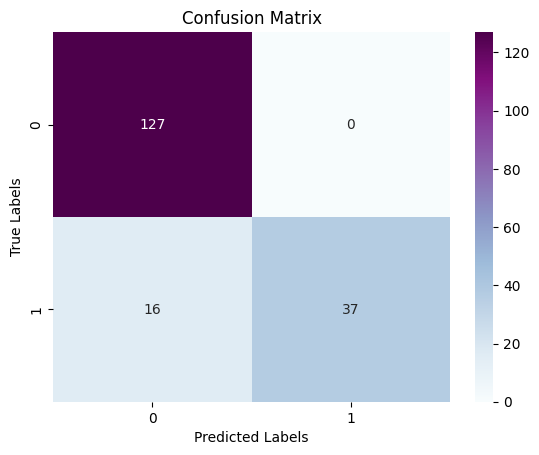

In [ ]:
svm_cm = confusion_matrix(y_valid, y_pred)

sns.heatmap(svm_cm, annot=True, fmt='d', cmap='BuPu')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

In [ ]:
accuracy = np.trace(svm_cm) / np.sum(svm_cm)        #np.trace gives sum of diagonal elements that is true positive and true negatives
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 91.11%


Model's accuracy : 91.11

In [ ]:
import joblib

# Save the model to a specific path
joblib.dump(svc, '/content/drive/MyDrive/ImplementationFinalProject/svm.pkl')


['/content/drive/MyDrive/ImplementationFinalProject/svm.pkl']

In [ ]:
# import joblib      #for loading it in future

# # Load the saved model
# svc_loaded = joblib.load('/content/drive/MyDrive/ImplementationFinalProject/svm.pkl')


In [ ]:
from google.colab import files   #download the model
files.download('/content/drive/MyDrive/ImplementationFinalProject/svm.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Random Forest**